In [2]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import IntegerComparator
import numpy as np 
from tqdm import tqdm

In [3]:
# https://qiskit.org/textbook/ch-algorithms/grover.html
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1) 
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [4]:
MEM_SIZE = 4
MEM_MAX = 2 ** MEM_SIZE - 1
def QramCircuit(nums, s_mem = 4):
    size = len(nums)
    s_addr = int(np.ceil(np.log2(size)))

    qc = QuantumCircuit(s_addr + s_mem)

    lastflips = [0] * s_addr

    for i in range(size):
        val = nums[i]
        
        # change all 0 bits to 1

        # if j's bit is 0, flip it to 1
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 0
            flip ^= lastflips[j]
            if flip:
                qc.x(j)
            t_addr >>= 1
        
        # apply toffoli gates to map address to memory
        t_val = val
        for j in range(s_mem):
            one = (t_val & 1)
            if one:
                qc.mct(list(range(s_addr)), s_addr + j)
            t_val >>= 1
        
        # flip back
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 0
            lastflips[j] = flip
            t_addr >>= 1

    qc.name = 'qram'

    return qc

In [5]:
def QramCircuit1(nums, s_mem = 4):
    size = len(nums)
    s_addr = int(np.ceil(np.log2(size)))

    qc = QuantumCircuit(s_addr + s_mem)

    for i in range(size):
        val = nums[i]
        
        # change all 0 bits to 1

        # if j's bit is 0, flip it to 1
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 0
            if flip:
                qc.x(j)
            t_addr >>= 1
        
        # apply toffoli gates to map address to memory
        t_val = val
        for j in range(s_mem):
            one = (t_val & 1)
            if one:
                qc.mct(list(range(s_addr)), s_addr + j)
            t_val >>= 1
        
        # flip back
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 0
            if flip:
                qc.x(j)
            t_addr >>= 1

        qc.barrier()

    qc.name = 'qram'

    return qc

In [6]:
def comparator_oracle(n, value):
    qc = QuantumCircuit(n * 2 + 1)
    ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
    ici = ic.inverse()
    qc.append(ic, qc.qubits[:-1])
    qc.cx(n, n*2)
    qc.append(ici, qc.qubits[:-1])
    qc.name = f"cmp_{value}"
    return qc

In [7]:
# https://qiskit.org/textbook/ch-algorithms/grover.html
def grover(arr_len, value):
    n = MEM_SIZE
    iter = max(int(np.pi / 4 * np.sqrt(arr_len)), 1)

    qc = QuantumCircuit(n * 2 + 1, n)
    qc.x(n * 2)
    qc.h(list(range(n)) + [n * 2])

    qc.barrier()

    for i in range(iter):
        qc.append(comparator_oracle(n, value))
        qc.append(diffuser(n), qc.qubits[0:n])

        qc.barrier()

    qc.measure(qc.qubits[0:n], qc.clbits[:])
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=sim).result().get_counts()
    return int(list(counts.keys())[0], 2)

In [8]:
def groverQram(qram, arr_len, value):
    m = max(int(np.ceil(np.log2(arr_len))), 1)
    n = MEM_SIZE
    iter = max(int(np.pi / 4 * np.sqrt(arr_len)), 1)

    clen = m + n * 2 + 1
    qc = QuantumCircuit(clen, m)
    qc.x(clen - 1)
    qc.h(list(range(m)) + [clen - 1])

    ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
    ici = ic.inverse()

    qc.name = f"cmp_{value}"


    for i in range(iter):
        qc.append(qram, qc.qubits[0:m+n])
        qc.append(ic, qc.qubits[m: clen - 1])
        qc.cx(m + n, clen - 1)
        qc.append(ici, qc.qubits[m: clen - 1])
        qc.append(qram, qc.qubits[0:m+n])

        qc.append(diffuser(m), qc.qubits[0:m])


    qc.measure(qc.qubits[0:m], qc.clbits[:])
    
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=sim).result().get_counts()
    return int(list(counts.keys())[0], 2)

In [9]:
def durrHoyer(nums, iter = None):
    n = len(nums)
    if n == 0:
        return
    if n == 1:
        return nums[0], 0
    if n == 2:
        return nums[0], 0 if nums[0] < nums[1] else nums[1], 1
        
    thres = np.random.randint(n)
    if iter is None:
        iter = int(22.5 * np.sqrt(n) + 1.4 * np.log2(n))
    gmin = thres
    print('running iter:', iter)
    for i in range(iter):
        nmin = grover(n, thres)
        if nmin < gmin:
            gmin = nmin
            thres = gmin
    return gmin

In [10]:
def durrHoyerQram(nums, iter = None):
    n = len(nums)
    if n == 0:
        return
    if n == 1:
        return nums[0], 0
    if n == 2:
        return (nums[0], 0) if nums[0] < nums[1] else (nums[1], 1)
        
    qram = QramCircuit(nums, MEM_SIZE)
    gargmin = np.random.randint(n)
    gmin = nums[gargmin]
    if iter is None:
        iter = int(22.5 * np.sqrt(n) + 1.4 * np.log2(n))
    print('running iter:', iter)
    for i in tqdm(range(iter)):
        argmin = groverQram(qram, n, gmin)
        if argmin >= n:
            continue
        nmin = nums[argmin]
        if nmin < gmin:
            gmin = nmin
            gargmin = argmin
    return gmin, gargmin

In [11]:
def createDAG(adjm):
   # N is number of vertexes
   # M is number of edges

   inf = 2 ** MEM_SIZE - 1
   size = int(np.sqrt(len(adjm)))
   res = []
   
   for i in range(0, int(len(adjm) / size)):
      mslice = adjm[i * size : i * size + size]
      mslice = list(map(lambda x: inf if x == 0 else x, mslice))
      mslice[i] = 0
      res.append(mslice)

   return res

In [12]:
def QuantumShortestPath(adjm, s_index, d_index, repeat=False):
    n = len(adjm)
    s = 0
    h = [MEM_MAX] * n
    p = [np.inf] * n
    h[s] = 0
    iter = 1
    if repeat:
        iter = int(np.ceil(2 * np.log2(n)))

    for i in range(s + 1, n):
        for _ in range(iter):
            nums = [h[i]] + [min(h[j] + adjm[j][i], MEM_MAX) for j in range(i)]
            h[i], p[i] = durrHoyerQram(nums)
            p[i] -= 1

    cur = d_index
    path = [s_index]
    p_len = h[d_index]
    while cur != s_index:
        path.insert(1, cur)
        cur = p[cur]
    return {'path': path, 'length': p_len}

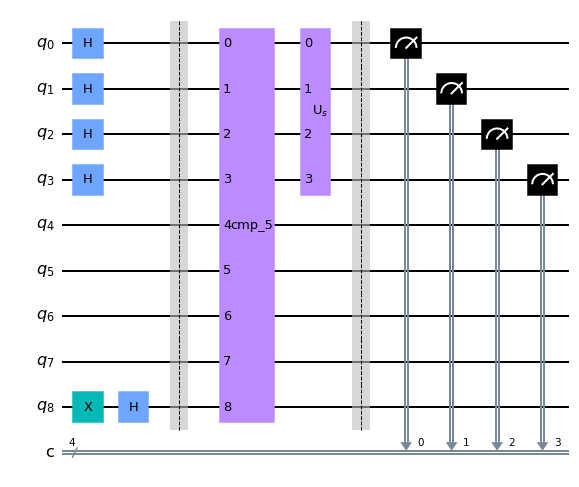

In [13]:

n = 4
value = 5
iter = int(np.pi / 4 * np.sqrt((2 ** n) / value))

qc = QuantumCircuit(n * 2 + 1, n)
qc.x(n * 2)
qc.h(list(range(n)) + [n * 2])

qc.barrier()

for i in range(iter):
    qc.append(comparator_oracle(n, value), qc.qubits[0: n*2+1])
    qc.append(diffuser(4), qc.qubits[0:n])

    qc.barrier()

qc.measure(qc.qubits[0:n], qc.clbits[:])
qc.draw('mpl')

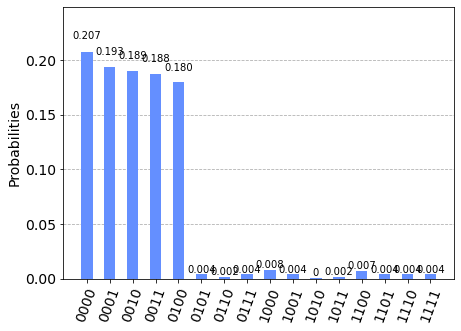

In [14]:
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
plot_histogram(counts)

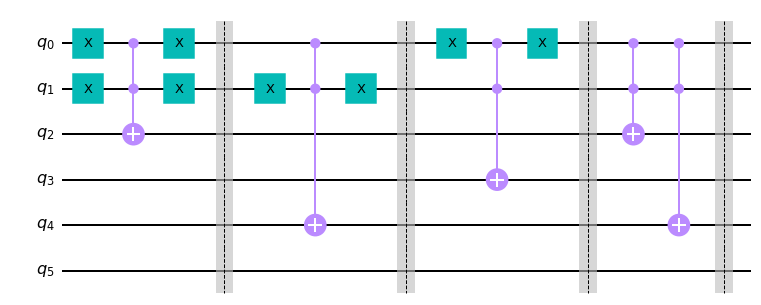

In [15]:
nums = [1, 4, 2, 5]
qram = QramCircuit1(nums, 4)
qram.draw('mpl')


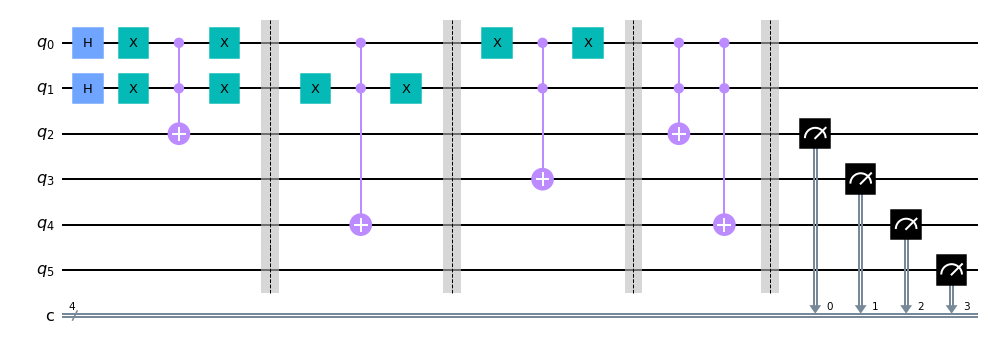

In [16]:
m = int(np.ceil(np.log2(len(nums))))

qc = QuantumCircuit(6, 4)
qc.h([0, 1])
qc = qc.compose(qram, [0, 1, 2, 3, 4, 5])
qc.measure(qc.qubits[2:6], qc.clbits[:])
qc.draw('mpl')

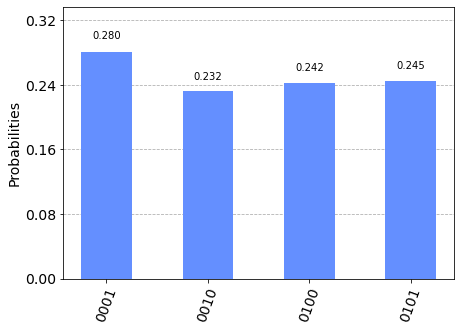

In [17]:
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
plot_histogram(counts)

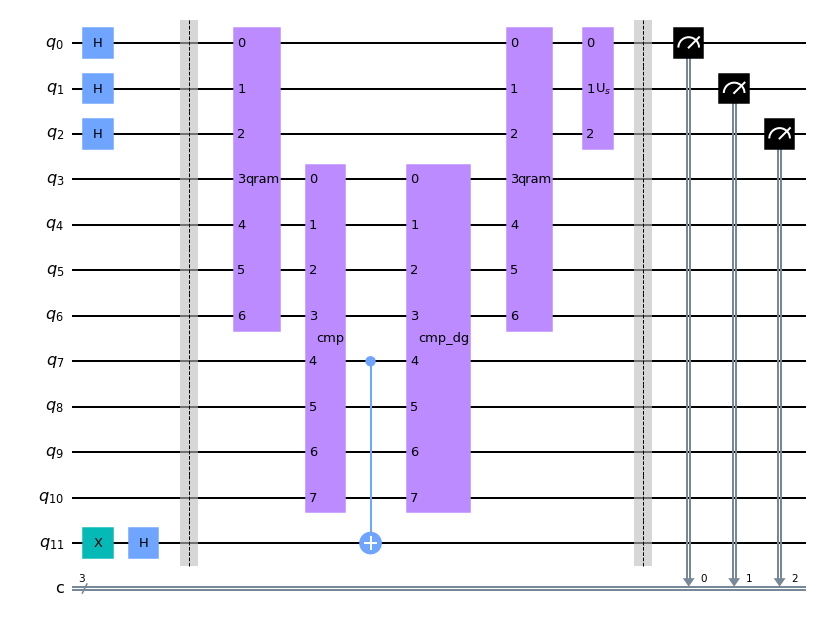

In [18]:
nums = [11, 15, 10, 7, 9, 1, 0, 4]

n = 4
m = int(np.ceil(np.log2(len(nums))))
value = 2
iter = max(int(np.pi / 4 * np.sqrt(len(nums)/2)), 1)
# iter = max(int(np.sqrt((16/4))), 1)
# iter = 2

clen = m + n * 2 + 1
qc = QuantumCircuit(clen, m)
qc.x(clen - 1)
qc.h(list(range(m)) + [clen - 1])
# qc.barrier()

qram = QramCircuit(nums, 4)

ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
ici = ic.inverse()

qc.name = f"cmp_{value}"


# qc.barrier()

for i in range(iter):
    
    qc.barrier()
    qc.append(qram, qc.qubits[0:m+n])
    qc.append(ic, qc.qubits[m: clen - 1])
    qc.cx(m + n, clen - 1)
    qc.append(ici, qc.qubits[m: clen - 1])

    # qc.append(diffuser(n), qc.qubits[m:m+n])
    qc.append(qram, qc.qubits[0:m+n])
    qc.append(diffuser(m), qc.qubits[0:m])



qc.barrier()

qc.measure(qc.qubits[0:m], qc.clbits[:])
qc.draw('mpl')


In [19]:
ans = []
for i, v in enumerate(nums):
    if v < value:
        ans.append('{0:04b}'.format(i))
ans

['0101', '0110']

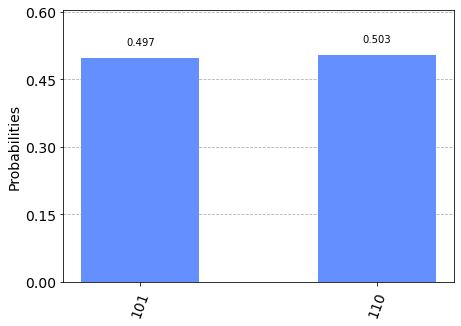

In [20]:
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
plot_histogram(counts)

In [15]:
# nums = [16, 16, 16, 16, 16, 16, 16, 16, 3, 16]
nums = [11, 15, 10, 7, 9, 1, 0]
durrHoyerQram(nums)

running iter: 63


100%|██████████| 63/63 [00:10<00:00,  5.92it/s]


(0, 6)

In [182]:
# https://graphonline.ru/en/
adjm = [
0, 2, 1, 4, 0, 
0, 0, 3, 2, 3, 
0, 0, 0, 1, 5, 
0, 0, 0, 0, 2, 
0, 0, 0, 0, 0
]
# adjm = [
# 0, 2, 3, 1, 0, 
# 0, 0, 0, 0, 3, 
# 0, 0, 0, 0, 1, 
# 0, 0, 0, 0, 1, 
# 0, 0, 0, 0, 0
# ]
adjm = createDAG(adjm)
QuantumShortestPath(adjm, 0, 4)

running iter: 41


100%|██████████| 41/41 [00:07<00:00,  5.29it/s]


running iter: 47


100%|██████████| 47/47 [00:06<00:00,  7.15it/s]


running iter: 53


100%|██████████| 53/53 [00:07<00:00,  6.83it/s]


{'path': [0, 2, 3, 4], 'length': 4}